In [41]:
import pandas as pd
import glob
import tensorflow as tf

# Define the path where your CSV files are located
csv_files_path = '../csv_files/*.csv'

# Uncomment this section if you need to recreate a random 1% sample
# data_frames = []
# for file in glob.glob(csv_files_path):
#     df = pd.read_csv(file, header=None)  # Load without headers
#     if df.shape[1] == 7:                 # Ensure it has exactly 7 columns
#         data_frames.append(df)           # Append if structure is correct
#     else:
#         print(f"Skipping file {file} due to unexpected number of columns: {df.shape[1]}")
# 
# # Concatenate all valid DataFrames
# all_data = pd.concat(data_frames, ignore_index=True)
# 
# # Assign column names
# all_data.columns = ['x', 'y', 'z', 'p_id', 'xi1', 'xi2', 'gn']
# 
# # Drop any rows with NaN values
# all_data.dropna(inplace=True)
# 
# # Randomly sample 1% of the data
# sampled_data = all_data.sample(frac=0.01, random_state=42)
# 
# # Save the sample
# sampled_data.to_csv('sampled_data_1_percent.csv', index=False)

# Load the pre-saved 1% sampled data
sampled_data = pd.read_csv('sampled_data_1_percent.csv')

# Split into features (x, y, z) and labels (p_id, gn, xi1, xi2)
features = sampled_data[['x', 'y', 'z']].values
labels = sampled_data[['p_id', 'xi1', 'xi2', 'gn']].values

# Convert to TensorFlow dataset with (features, labels) tuples
sampled_data = tf.data.Dataset.from_tensor_slices((features, labels))

# Define the split ratio (80% train, 20% test)
train_size = int(0.8 * len(sampled_data))
train_data = sampled_data.take(train_size)
test_data = sampled_data.skip(train_size)

# Print dataset sizes to confirm
print(f"Total data size (1% sample): {len(sampled_data)}")
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")


Total data size (1% sample): 80000
Training set size: 64000
Test set size: 16000


In [42]:
import tensorflow as tf

def custom_loss(y_true, y_pred):
    # y_true and y_pred shapes are both (batch_size, 288)
    loss = 0
    for i in range(96):  # Loop through each patch
        p_id_true = y_true[:, i]      # True class label (one-hot encoded)
        xi1_true = y_true[:, 96 + i]  # True xi1 value for patch i
        xi2_true = y_true[:, 192 + i] # True xi2 value for patch i

        p_id_pred = y_pred[:, i]      # Predicted probability for patch i
        xi1_pred = y_pred[:, 96 + i]  # Predicted xi1 for patch i
        xi2_pred = y_pred[:, 192 + i] # Predicted xi2 for patch i

        # MSE loss for only the target patch
        loss += tf.reduce_sum(p_id_true * (tf.square(p_id_true - p_id_pred) +
                                           tf.square(xi1_true - xi1_pred) +
                                           tf.square(xi2_true - xi2_pred)))
    return loss


In [43]:
# Verify the shapes of features and labels
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

# Configure training and test data for batching and shuffling
batch_size = 32
train_data = train_data.batch(batch_size).shuffle(1000)
test_data = test_data.batch(batch_size)

# Display one batch to confirm
for batch_features, batch_labels in train_data.take(1):
    print("Batch features:", batch_features.numpy())
    print("Batch labels:", batch_labels.numpy())


Features shape: (80000, 3)
Labels shape: (80000, 4)
Batch features: [[-2.91718906  1.73263867  0.97019972]
 [ 0.87133129 -1.03767129  0.91796048]
 [-0.02844229  0.34748369 -0.2313029 ]
 [-1.92270247 -1.33716426 -2.60818852]
 [ 2.62352195 -2.1233333   1.93662574]
 [-0.97557238  2.96804717 -1.85071948]
 [-0.26522482  2.89317393 -0.12682441]
 [-2.06477198  0.04799072  1.44035292]
 [ 3.76007805  2.55624434 -1.45892515]
 [-2.20684149 -1.29972764  0.99631934]
 [-0.02844229 -1.14998115 -0.62309723]
 [ 1.81846137  0.04799072 -0.80593459]
 [ 2.48145243  0.04799072  1.93662574]
 [ 1.81846137 -0.55099521  0.10825219]
 [ 0.11362722 -0.58843183 -1.11937006]
 [ 1.34489633 -3.20899531 -0.64921686]
 [ 1.96053089  3.49215986  0.89184085]
 [ 4.04421708  3.15523027 -0.4663795 ]
 [-3.81696264 -1.82384033 -0.88429346]
 [ 3.09708699 -1.89871357 -1.45892515]
 [ 1.20282682 -0.92536142 -1.85071948]
 [ 1.62903536 -3.20899531 -1.8768391 ]
 [ 2.95501748  3.45472324 -1.24996817]
 [ 2.52880894  1.9572584   1.962745

In [45]:
from tensorflow.keras import layers, models

# Define the model architecture
model = models.Sequential()

# Input layer (assuming (x, y, z) as input)
model.add(layers.Input(shape=(3,)))

# Dense layer to increase dimensionality
model.add(layers.Dense(128, activation='relu'))

# Dense layer to increase dimensionality
model.add(layers.Dense(512, activation='relu'))

# # Reshape layer to prepare for convolutional layer (reshape to 16x8)
# model.add(layers.Reshape((16, 8, 1)))  # Adjust dimensions if necessary

# # 96 Convolutional filters to allow patch-specific feature learning
# model.add(layers.Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'))

# # Pooling layer to reduce dimensionality
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Reshape layer to prepare for convolutional layer (reshape to 16x8)
model.add(layers.Reshape((8, 8, 8, 1)))  # Adjust dimensions if necessary

# 96 Convolutional filters to allow patch-specific feature learning
model.add(layers.Conv3D(96, kernel_size=(3, 3, 3), activation='relu', padding='same'))

# Pooling layer to reduce dimensionality
model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output from the convolutional layers
model.add(layers.Flatten())

# Dense layer for further feature processing
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))  # Regularization to prevent overfitting

# Output layer with 4 outputs: (p_id, gn, xi1, xi2)
model.add(layers.Dense(4, activation=None))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 8, 8, 8, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 8, 8, 96)    │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 4, 4, 4, 96)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     1,573,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,643,396 (6.27 MB)

 Trainable params: 1,643,396 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 82.3147 - mae: 3.9263 - val_loss: 20.2049 - val_mae: 1.7549
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 22.2670 - mae: 1.9011 - val_loss: 17.6750 - val_mae: 1.5299
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 18.6249 - mae: 1.6837 - val_loss: 15.1959 - val_mae: 1.4458
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 16.8763 - mae: 1.5919 - val_loss: 13.6127 - val_mae: 1.2839
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 15.4997 - mae: 1.5088 - val_loss: 12.3863 - val_mae: 1.1531
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 14.3995 - mae: 1.4533 - val_loss: 11.8533 - val_mae: 1.2840
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 13.5059 - mae: 1.3853 - val_loss: 10.1718 - val_mae: 1.0268
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 12.9621 - mae: 1.3496 - val_loss: 9.5952 - val_mae: 1.0063
Epoch 9/2

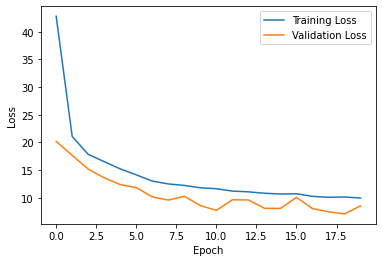

In [46]:
# Set training parameters
epochs = 20

# Train the model
history = model.fit(train_data, 
                    validation_data=test_data, 
                    epochs=epochs)

# Optional: Plotting training history
import matplotlib.pyplot as plt

# Plot loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [48]:
import numpy as np

# Number of samples to display for comparison
num_samples = 5

# Take a batch from the test set
for test_features, test_labels in test_data.take(1):
    # Make predictions on the batch
    predictions = model.predict(test_features)

    # Randomly select a few samples for comparison
    indices = np.random.choice(range(len(test_features)), num_samples, replace=False)
    print("Sample Comparisons (Predicted vs True):\n")
    
    for i in indices:
        print(f"Sample {i + 1}:")
        print("Predicted ->", predictions[i])
        print("True      ->", test_labels[i].numpy())
        print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Sample Comparisons (Predicted vs True):

Sample 29:
Predicted -> [75.93515     0.46240932  1.1096538   0.54994076]
True      -> [74.          0.32543478  0.96304629  0.93024229]
------------------------------
Sample 7:
Predicted -> [6.9284668e+01 4.4017032e-01 8.8737011e-03 5.9876955e-01]
True      -> [64.          0.5463529  -0.47132739  0.07351903]
------------------------------
Sample 5:
Predicted -> [72.26279     0.4420906   0.35749042  0.560473  ]
True      -> [73.          0.47482923  0.22119026  0.39292454]
------------------------------
Sample 1:
Predicted -> [24.02546     0.44734767  0.40792617  0.57101864]
True      -> [25.          0.75540607 -0.15596034  0.38312163]
------------------------------
Sample 28:
Predicted -> [37.63916     0.44675845 -0.17172176  0.5591159 ]
True      -> [35.          0.23221757 -0.54615843  0.3104432 ]
------------------------------


In [49]:
# Save the model in the .keras format
model_name = 'ALL_REGRESSION_128_512_CONV3D_256_20EPOCHS'

model.save(model_name+'.keras')

import json

# Save the training history
with open(model_name+'.json', 'w') as f:
    json.dump(history.history, f)


# To later load doing:
# from tensorflow.keras.models import load_model
# model = load_model('my_model.keras')

# with open('training_history.json', 'r') as f:
#     history_data = json.load(f)

In [54]:
model.name

'sequential_3'